<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Applied-Modeling/blob/master/NB_project2_AlldataCalendar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

#Load neccessary libraries

In [0]:
import sys
import pandas as pd
import locale
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Load data files

In [0]:
listings = pd.read_csv('listings.csv')
listings_April2019 = pd.read_csv('listings_April2019.csv')
listings_Aug2019 = pd.read_csv('listings_Aug2019.csv')
listings_Aug2018 = pd.read_csv('listings_Aug2018.csv')
listings_Dec2018 = pd.read_csv('listings_Dec2018.csv')
listings_Feb2019 = pd.read_csv('listings_Feb2019.csv')
listings_Jan2019 = pd.read_csv('listings_Jan2019.csv')
listings_Jul2018 = pd.read_csv('listings_Jul2018.csv')
listings_Jul2019 = pd.read_csv('listings_Jul2019.csv')
listings_Jun2019 = pd.read_csv('listings_Jun2019.csv')
listings_Mar2019 = pd.read_csv('listings_Mar2019.csv')
listings_May2019 = pd.read_csv('listings_May2019.csv')
listings_Nov2018 = pd.read_csv('listings_Nov2018.csv')
listings_Oct2018 = pd.read_csv('listings_Oct2018.csv')
listings_Sep2018 = pd.read_csv('listings_Sep2018.csv')
calendar = pd.read_csv('calendar.csv')

listings_all = pd.concat([listings, listings_April2019, listings_Aug2019, listings_Aug2018,listings_Dec2018, listings_Feb2019, listings_Jan2019, 
                          listings_Jul2018, listings_Jul2019, listings_Jun2019, listings_Mar2019, listings_May2019, listings_Nov2018, listings_Oct2018, listings_Sep2018], ignore_index=True)



In [0]:
listings_all.shape

In [0]:
listings.isnull().sum()

In [0]:
listings['id'].nunique()

# Merge Listings data with Calendar data

In [0]:
new_calendar = calendar.drop(columns=['available', 'adjusted_price', 'minimum_nights', 'maximum_nights']) # Dont need these extra columns for now

In [0]:
new_calendar['price']=new_calendar.price.map(lambda x: locale.atof(x.strip('$'))) #Convert price to Int


In [0]:
new_calendar = new_calendar.pivot_table('price', 'listing_id','date' ) # Pivot in order to merge on id

In [0]:
SantaClaraListings = pd.merge(listings,new_calendar, how='outer', left_on='id', right_on='listing_id')

In [0]:
SantaClaraListings.shape

In [0]:
import pandas_profiling

profile_report = SantaClaraListings.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [59]:
SantaClaraListings.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,...,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15
count,7.435000e+03,7.435000e+03,0.0,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,6098.000000,7435.000000,7435.000000,900.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.00000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,...,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,6541.000000
mean,2.320935e+07,7.548259e+07,NaN,37.354201,-121.971274,164.619906,7.661063,28.255817,1.745308,33.341089,192.167048,156.900000,158.521049,158.512979,156.385205,159.033894,159.353732,156.503430,158.178615,158.958036,159.342703,158.237660,159.211029,159.617754,156.661063,157.75037,159.448420,159.699395,158.066443,160.196100,160.443847,157.719301,160.836987,159.580229,159.677875,157.895225,160.421385,160.582112,157.575252,159.320377,...,170.528850,170.481641,167.002959,167.790451,169.838870,167.212374,166.900471,169.400807,169.397176,167.713248,166.671284,166.850437,166.924815,166.682582,169.044385,169.096839,166.444923,166.762609,166.907599,166.983726,166.715669,171.253262,169.185474,165.765434,166.521049,166.535440,166.041964,165.812105,168.377001,168.328447,165.008070,165.701009,165.818561,165.889173,165.674647,168.631204,170.074781,165.684331,169.549294,166.980584
std,1.089957e+07,8.011168e+07,NaN,0.065136,0.109533,283.108458,22.711606,47.328919,1.854202,97.969377,136.399528,159.282635,276.613453,277.152470,275.663414,300.615706,300.797883,275.784666,276.049895,276.281952,276.450473,275.661491,300.469785,300.772299,275.372465,276.06109,276.279146,276.301771,275.514176,300.544246,300.646679,275.430443,276.759680,276.390429,276.383232,275.129666,300.370532,300.452978,275.138912,276.261215,...,304.918298,304.870787,279.587580,279.849955,284.024683,279.834711,279.627750,304.559797,304.583073,281.305434,279.392685,279.481200,279.496678,279.354952,304.343900,304.420737,279.793295,279.833647,279.902746,279.919548,279.805606,307.010013,304.748316,279.502222,279.672520,279.648889,279.392248,279.276677,304.336841,304.317947,279.089097,279.273339,279.295136,279.318597,279.216991,304.350285,305.114039,279.747516,282.793674,291.870509
min,4.952000e+03,2.077000e+03,NaN,36.965600,-122.197880,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,20.000000,15.000000,10.000000,15.000000,10.000000,10.000000,10.000000,15.000000,10.000000,15.000000,15.000000,10.000000,10.000000,10.000000,10.00000,15.000000,15.000000,15.000000,10.000000,10.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00

In [54]:
fig = px.scatter_mapbox(SantaClaraListings, lat="latitude", lon="longitude", hover_name="neighbourhood", hover_data=["price"], color='price', size='price',
                        zoom=3, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Price(the target) will need log transformation since its Right-Skewed

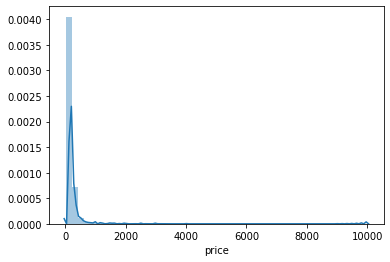

In [56]:
%matplotlib inline

sns.distplot(listings['price']);

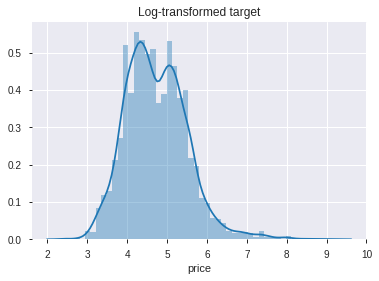

In [0]:
price_log = np.log1p(listings['price'])
sns.distplot(price_log)
plt.title('Log-transformed target'); # price here is log dollars

# Maybe even remove the outliers

In [0]:
listings = listings[(listings['price'] >= np.percentile(listings['price'], 0.5)) & 
        (listings['price'] <= np.percentile(listings['price'], 99.5)) & 
        (listings['latitude'] >= np.percentile(listings['latitude'], 0.05)) & 
        (listings['latitude'] < np.percentile(listings['latitude'], 99.95)) &
        (listings['longitude'] >= np.percentile(listings['longitude'], 0.05)) & 
        (listings['longitude'] <= np.percentile(listings['longitude'], 99.95))]

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(listings_all, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [0]:
train.shape, val.shape, test.shape

((62550, 16), (15638, 16), (19548, 16))

In [0]:
# The status_group column is the target
target = 'price'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'neighbourhood_group'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood', 'room_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



In [0]:
#Linear Regression

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    LinearRegression()
)

In [0]:
# Try Decision Tree

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(criterion='mse',max_depth=100)
)

In [0]:
# Try Random Forest

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators = 500, random_state = 42)
)

In [0]:
# Apply logarithmic transformation to data set before fitting the model

# using LinearRegression is better

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for LR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for LR: ', r2_score(y_val, y_pred))

MAE for LR:  16.429186918591252
R2 Score for LR:  0.8793466687017533


In [0]:
# using DecisionTreeRegressor is worse

from sklearn.metrics import mean_absolute_error

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(mean_absolute_error(y_val, y_pred))

70.3793991416309


In [0]:
# using RandomForestRegressor is best

from sklearn.metrics import mean_absolute_error

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for RFR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for RFR: ', r2_score(y_val, y_pred))

MAE for RFR:  16.429186918591252
R2 Score for RFR:  0.8793466687017533


In [0]:
rf.feature_importances_

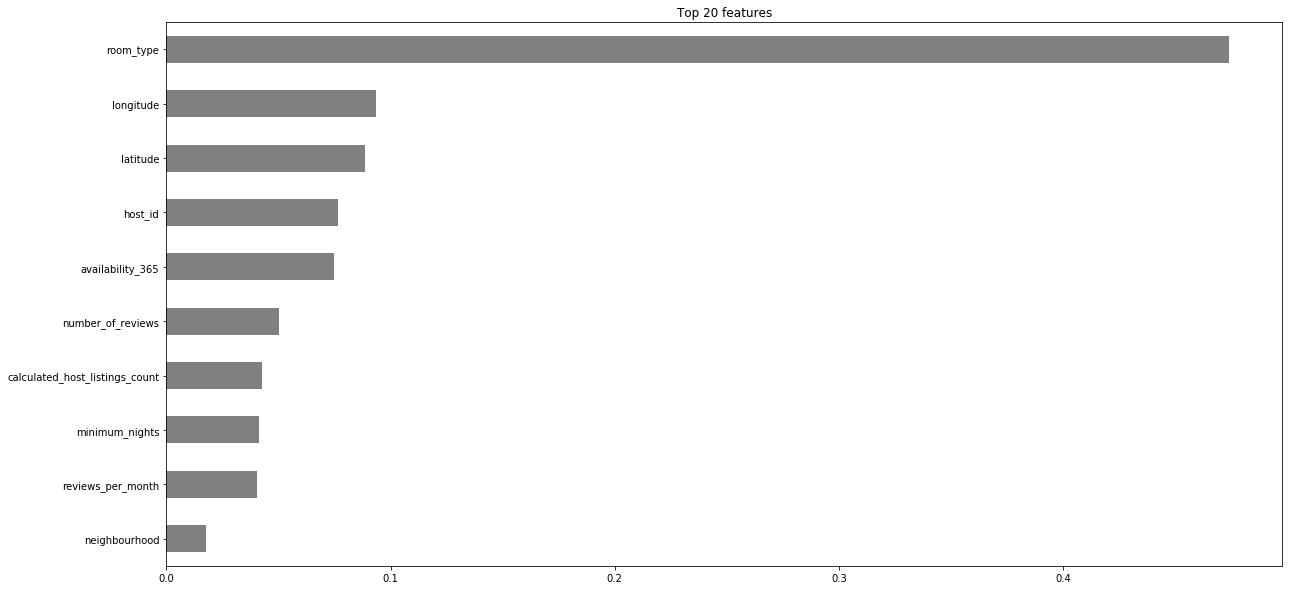

In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(20,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
X_train.columns

Index(['host_id', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'neighbourhood',
       'room_type'],
      dtype='object')

In [0]:
# Using Gradient Boosting (almost as good as linear regression)

from xgboost import XGBRFRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRFRegressor(n_estimators=500, random_state=42, n_jobs=-1, objective ='reg:squarederror' )
)

pipeline.fit(X_train, y_train)

In [0]:

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for GB: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for GB: ', r2_score(y_val, y_pred))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


MAE for GB:  77.59154740384906
R2 Score for GB:  0.17704016111588194


In [0]:
X_val['room_type'].describe()

count                1190
unique                  4
top       Entire home/apt
freq                  566
Name: room_type, dtype: object

In [0]:
#PDP Partial dependence plot

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = XGBRFRegressor(n_estimators=500, random_state=42, n_jobs=-1, objective ='reg:squarederror', max_depth=50, alpha = 100 )
model.fit(X_encoded, y_train)

XGBRFRegressor(alpha=100, base_score=0.5, colsample_bylevel=1,
               colsample_bynode=0.8, colsample_bytree=1, gamma=0,
               learning_rate=1, max_delta_step=0, max_depth=50,
               min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
               nthread=None, objective='reg:squarederror', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)

In [0]:
# Use Pdpbox - Automated version

feature = 'room_type'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

In [0]:
# Use Pdpbox - Manual version

%matplotlib inline

feature = 'room_type'
pdp_dist = pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp_plot(pdp_dist, feature);

In [0]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'room_type', 'data_type': dtype('O'), 'mapping': Hotel room         1
  Entire home/apt    2
  Private room       3
  Shared room        4
  NaN               -2
  dtype: int64}]

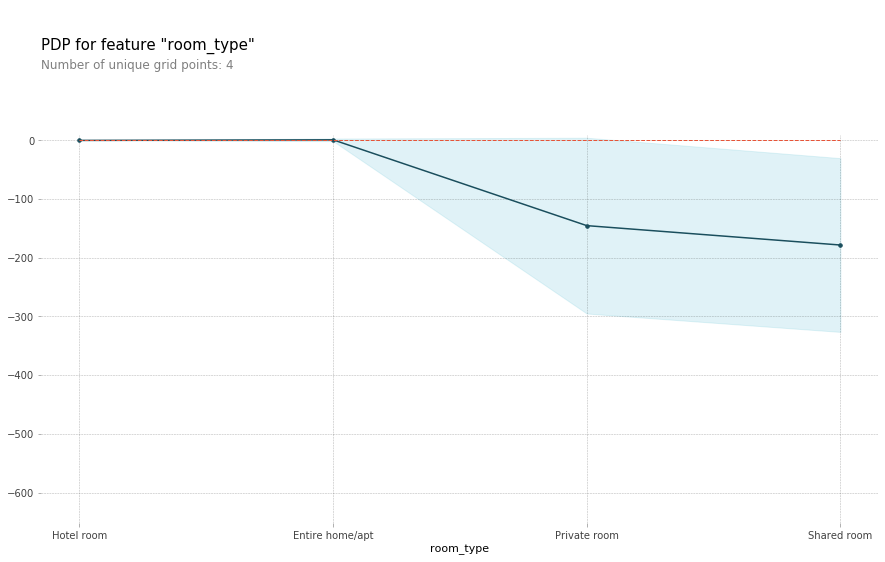

In [0]:
pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']);

In [0]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100) # Confusing parameter name

In [0]:
encoder.mapping

[{'col': 'neighbourhood',
  'data_type': dtype('O'),
  'mapping': San Jose                 1
  Mountain View            2
  Palo Alto                3
  Sunnyvale                4
  Cupertino                5
  Milpitas                 6
  Los Gatos                7
  Saratoga                 8
  Santa Clara              9
  Unincorporated Areas    10
  Los Altos               11
  Campbell                12
  Morgan Hill             13
  Los Altos Hills         14
  Gilroy                  15
  Monte Sereno            16
  NaN                     -2
  dtype: int64},
 {'col': 'room_type', 'data_type': dtype('O'), 'mapping': Hotel room         1
  Entire home/apt    2
  Private room       3
  Shared room        4
  NaN               -2
  dtype: int64}]

(None, <a list of 0 Text xticklabel objects>)

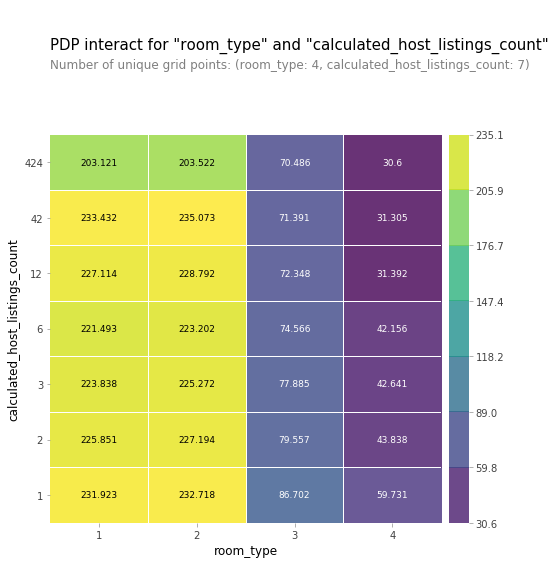

In [0]:
#PDP with 2 features

features = ['room_type', 'calculated_host_listings_count']

from pdpbox.pdp import pdp_interact_plot, pdp_interact

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'])

# Manually change the xticks labels


#plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], ['San Jose', 'Mountain View', 'Palo Alto', 'Sunnyvale', 'Cupertino', 'Milpitas', 
#                                                                     'Los Gatos', 'Saratoga', 'Santa Clara', 'Unincorporated Areas', 'Los Altos', 
#                                                                     'Campbell', 'Morgan Hill', 'Los Altos Hills', 'Gilroy', 'Monte Sereno'])


In [0]:
# With ELI5 library. This wont work unless its only numeric features

!pip install eli5

transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRFRegressor(
    n_estimators=1000, 
    max_depth=10, 
    objective='reg:squarederror', 
    n_jobs=-1, 
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=20)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', n_iter=3)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

[0]	validation_0-mae:61.4387	validation_1-mae:65.7062
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.


Weight,Feature
67.9495 ± 1.3528,room_type
18.5169 ± 0.6171,number_of_reviews
14.8581 ± 1.4043,availability_365
12.7564 ± 0.5428,longitude
12.2737 ± 0.1848,latitude
11.6193 ± 0.5466,calculated_host_listings_count
7.9349 ± 0.3397,minimum_nights
7.2149 ± 0.2554,host_id
5.5474 ± 0.5485,neighbourhood
5.0409 ± 0.1503,reviews_per_month


In [0]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(300, 700), 
    'max_depth': [50, 100, 150, 200, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=20, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
search.fit(X_train, y_train_log);


In [0]:
X_train_transformed

array([[ 3.66383250e+07,  3.72373528e+01, -1.21859483e+02, ...,
         8.30000000e+01,  1.00000000e+00,  1.00000000e+00],
       [ 3.65757300e+07,  3.73453152e+01, -1.21878941e+02, ...,
         3.45000000e+02,  2.00000000e+00,  2.00000000e+00],
       [ 1.51118800e+06,  3.73365356e+01, -1.21877846e+02, ...,
         3.51000000e+02,  2.00000000e+00,  1.00000000e+00],
       ...,
       [ 2.41801135e+08,  3.73480300e+01, -1.22014800e+02, ...,
         5.70000000e+01,  7.00000000e+00,  1.00000000e+00],
       [ 2.08373667e+08,  3.73892400e+01, -1.22078850e+02, ...,
         2.98000000e+02,  5.00000000e+00,  2.00000000e+00],
       [ 4.52579020e+07,  3.74272500e+01, -1.22081630e+02, ...,
         3.65000000e+02,  5.00000000e+00,  2.00000000e+00]])

In [0]:
# Shaply plot for predictions

def predict(room_type, longitude, latitude):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[room_type, longitude, latitude]], 
        columns=['room_type', 'longitude', 'latitude']
    )

    # Get the model's prediction
    pred = model.predict(df)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Get series with shap values, feature names, & feature values
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'${pred:,.0f} price. \n\n'
    result += f'Starting from baseline of ${explainer.expected_value:,.0f} \n'
    result += shaps.to_string()
    print(result)


    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict('Private room', 37.43972, -122.15672)

ValueError: ignored